<a href="https://colab.research.google.com/github/kirath2205/Machine-Learning-Plant-seedling/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip '/content/gdrive/MyDrive/train (1).zip'
!unzip '/content/gdrive/MyDrive/test (1).zip'

Streaming output truncated to the last 5000 lines.
  inflating: Charlock/c07c67078.png  
  inflating: Charlock/c0aac7fc2.png  
  inflating: Charlock/c0ae1e074.png  
  inflating: Charlock/c0e365810.png  
  inflating: Charlock/c19bc586d.png  
  inflating: Charlock/c1b1e4f9d.png  
  inflating: Charlock/c291766ce.png  
  inflating: Charlock/c2a1c8163.png  
  inflating: Charlock/c397b8d1a.png  
  inflating: Charlock/c39fea9e3.png  
  inflating: Charlock/c45aa7507.png  
  inflating: Charlock/c5cca5955.png  
  inflating: Charlock/c61d3ee3c.png  
  inflating: Charlock/c6368b901.png  
  inflating: Charlock/c7ac56c83.png  
  inflating: Charlock/c836af21e.png  
  inflating: Charlock/c842c829b.png  
  inflating: Charlock/c8b44af53.png  
  inflating: Charlock/c911db696.png  
  inflating: Charlock/c9601d3ab.png  
  inflating: Charlock/c97f86135.png  
  inflating: Charlock/c9a504525.png  
  inflating: Charlock/ca1aaeb27.png  
  inflating: Charlock/ca8f0f871.png  
  inflating: Charlock/caa43063c.png  

In [3]:
seedling_classes = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 
                    'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [4]:
import cv2
import numpy as np

# References
#   - Gábor Vecsei (Kaggle)
#   - OpenCV Docs (https://docs.opencv.org/3.4/d7/d37/tutorial_mat_mask_operations.html)

"""
Creating a mask to extract the relevant features from the plant images.

    Args:
        - image: OpenCV Image 
"""
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sensitivity = 35
    
    # Get pixels from image in the following (Hue, Saturation, Lightness) range
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

"""
Applying the mask on the image.

    Args:
        - image: OpenCV Image
"""
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

In [5]:
seedling_classes = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 
                    'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [6]:
import cv2
import numpy as np
import os



total_images = []
total_labels = []

for cls in seedling_classes:

    cur_dir = '/content/'+cls
    class_num=seedling_classes.index(cls)

    for filename in os.listdir(cur_dir):
        try:
            img = cv2.imread(cur_dir+"/"+filename, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (150, 150))
            img = segment_plant(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (45,45))
            img = img.flatten()
            
            
            total_images.append(img)
            total_labels.append(class_num)
        except Exception as e:
            print(e)
            pass
 

In [7]:
from sklearn.preprocessing import StandardScaler
total_images = StandardScaler().fit_transform(total_images)

In [8]:
total_labels = np.array(total_labels)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(total_images, total_labels, test_size=0.1, random_state=42)

In [17]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
scores = []
# Using the standard K-Nearest Neighbours Classifer from SkLearn
for n in n_neighbors:
    knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=n))
    # Fitting on the data
    knn.fit(X_train,y_train)
    scores.append(knn.score(X_val, y_val))

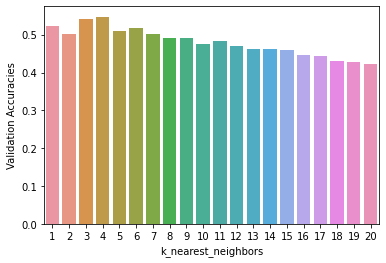

In [19]:
import seaborn as sns
import pandas as pd
d = pd.DataFrame({'k_nearest_neighbors': n_neighbors, 'Validation Accuracies': scores})
ax = sns.barplot(x="k_nearest_neighbors", y="Validation Accuracies", data=d)

In [22]:
max_neighbor = 1
max_val_score = scores[0]

for i in range(20):
    if scores[i]>max_val_score:
        max_val_score = scores[i]
        max_neighbor = n_neighbors[i]

print("Best value of K: "+str(max_neighbor))
print("Best cross-validation score: "+str(max_val_score))


Best value of K: 4
Best cross-validation score: 0.5473684210526316


In [24]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=max_neighbor))
knn.fit(total_images,total_labels)

OneVsRestClassifier(estimator=KNeighborsClassifier(n_neighbors=4))

In [25]:
test_images =[]
test_image_names = []


for filename in os.listdir('/content'):
    if filename.endswith('png'):
        test_image_names.append(filename)
        try:
            img = cv2.imread("/content/"+filename, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (150, 150))
            img = segment_plant(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (45,45))
            img = img.flatten()
            test_images.append(img)
        except Exception as e:
            print(e)
            pass



In [26]:
test_images = StandardScaler().fit_transform(test_images)

In [27]:
y_pred = knn.predict(test_images)

In [28]:
import pandas as pd
sub_d = {'file': [], 'species': []}
for i in range(len(test_image_names)):
    sub_d['file'].append(test_image_names[i])
    sub_d['species'].append(seedling_classes[y_pred[i]])
sub_df = pd.DataFrame(sub_d)

In [29]:
sub_df.head()

,file,species
0,148bbda66.png,Charlock
1,44e8b8833.png,Small-flowered Cranesbill
2,ace8761dd.png,Fat Hen
3,fadc6adbc.png,Charlock
4,cbe761896.png,Charlock


In [30]:
sub_df.to_csv('/content/submission.csv', index=False)